In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import torchvision.models as models
import torchvision.models as models

In [2]:
path=r"C:\Users\marut\Documents\Chest_X_Ray_Dataset"
image_path=[]
image_categories=[]
category=['COVID19','NORMAL','PNEUMONIA','TURBERCULOSIS']
dict_loc_cat=dict()
for cat in category:
    location=path+"\\"+ cat
    all_files = os.listdir(location)
    for files in all_files:
        image_path.append(location+"\\"+files)
        image_categories.append(cat)
        
dict_loc_cat['image_location']=image_path
dict_loc_cat['disease']=image_categories
disease_data=pd.DataFrame(dict_loc_cat)
disease_data.head()
print(disease_data.size)

14264


(2000, 2000)
COVID19


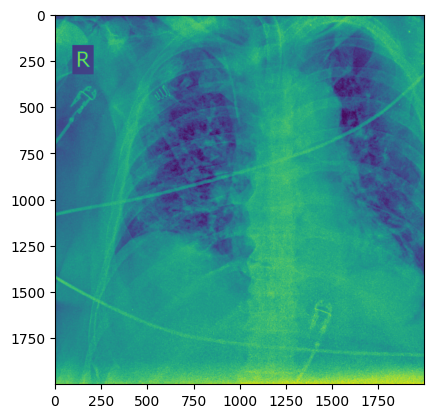

In [3]:
import matplotlib.image as mpimg
image=mpimg.imread(disease_data['image_location'][0])
plt.imshow(image)
print(image.shape)
print(disease_data['disease'][0])

In [4]:
print(disease_data['disease'].value_counts())

disease
PNEUMONIA        4273
NORMAL           1583
TURBERCULOSIS     700
COVID19           576
Name: count, dtype: int64


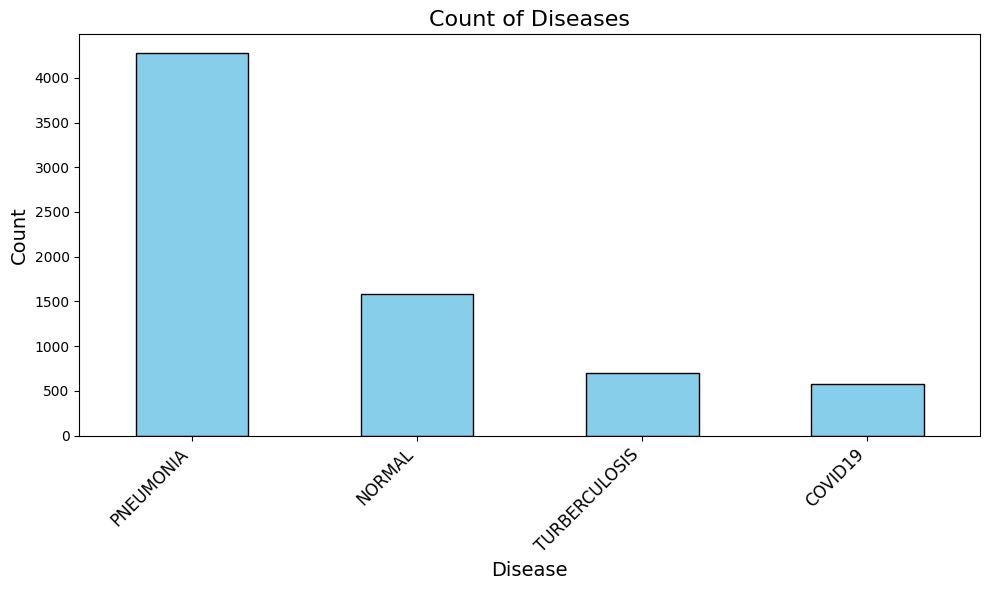

In [5]:
import matplotlib.pyplot as plt
disease_counts = disease_data['disease'].value_counts()
plt.figure(figsize=(10, 6))
disease_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Count of Diseases', fontsize=16)
plt.xlabel('Disease', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()


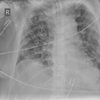

In [6]:
from PIL import Image
image = Image.open(disease_data['image_location'][0])
new_size = (100, 100)  
resized_image = image.resize(new_size)
resized_image


In [7]:
from sklearn.model_selection import train_test_split
X=disease_data['image_location']
Y=disease_data['disease']
train_X, test_X, train_Y, test_Y= train_test_split(X,Y,random_state=42,test_size=0.2)
train_X,validation_X, train_Y,validation_Y=train_test_split(train_X,train_Y,random_state=42,test_size=0.2)

In [8]:
from torch.utils.data import Dataset
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True) 
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        if index >= len(self.image_paths) or index < 0:
            raise IndexError("Index out of range")
        img_path = self.image_paths[index]
        image = Image.open(img_path)
        image = image.convert('L')
        if self.transform:
            image = self.transform(image)
        label = self.labels[index]
        return image, label

In [9]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [10]:
from torch.utils.data import DataLoader
train_dataset = ImageDataset(train_X, train_Y, transform=transform)
validation_dataset=ImageDataset(validation_X, validation_Y, transform=transform)
test_dataset = ImageDataset(test_X, test_Y, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [11]:
import torch
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda")
print(device)

cuda


In [12]:
import torch.nn as nn
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=2)
        self.pool1=nn.MaxPool2d(kernel_size=3,stride=1)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2)
        self.pool2=nn.MaxPool2d(kernel_size=3,stride=1)
        # dummy_input = torch.randn(1, 1, 128, 128)  # Assuming 28x28 image size
        # x = self.pool1(torch.relu(self.conv1(dummy_input)))
        # x = self.pool2(torch.relu(self.conv2(x)))
        # flattened_size = x.numel()  # This will give us the number of features after flattening
        # print(flattened_size)
        self.fc1 = nn.Linear(50176, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout=nn.Dropout(0.2)
    def forward(self,x):
        x=self.pool1(torch.relu(self.conv1(x)))
        x=self.pool2(torch.relu(self.conv2(x)))
        x=torch.flatten(x, start_dim=1)
        x=torch.relu(self.fc1(x))
        x=self.dropout(x)
        x=self.fc2(x)
        return x 

In [13]:
model = ConvNeuralNet(len(category))
loss_function=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.005)

In [14]:
def lables_converter(lables):
    category_dict={'COVID19':0,'NORMAL':1,'PNEUMONIA':2,'TURBERCULOSIS':3}
    lables_mapped=[]
    for i in lables:
        lables_mapped.append(category_dict[i])
    return torch.tensor(lables_mapped)

In [15]:
num_epochs=20
training_loss_sgd=[]
training_accuracy_sgd=[]
validation_accuracy_sgd=[]
model = model.to(device)
for epoch in range(num_epochs):
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=True)
    for i, (images, labels) in enumerate(train_loader_tqdm): 
        lables_mapped=lables_converter(labels)
        images = images.to(device)
        labels = lables_converter(labels).to(device)
        outputs = model(images)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    training_loss_sgd.append(loss.item())
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item())) 
    with torch.no_grad():
        correct = 0
        total = 0
        train_loader_tqdm = tqdm(train_loader, desc="Training Testing", leave=True)
        for images, labels in train_loader_tqdm:
            images = images.to(device)
            lables_mapped=lables_converter(labels)
            labels = lables_mapped.to(device)
            outputs = model(images)
            values, predicted = torch.max(outputs.data, 1)
            total = total+ labels.size(0)
            correct = correct+ (predicted == labels).sum().item()
        training_accuracy_sgd.append(correct / total)
        print('Accuracy Traing images: {} %'.format(100 * correct / total))
    with torch.no_grad():
        correct = 0
        total = 0
        validation_loader_tqdm = tqdm(validation_loader, desc="Validating", leave=True)
        for images, labels in validation_loader_tqdm:
            images = images.to(device)
            lables_mapped=lables_converter(labels)
            labels = lables_mapped.to(device)
            outputs = model(images)
            values, predicted = torch.max(outputs.data, 1)
            total = total+ labels.size(0)
            correct = correct+ (predicted == labels).sum().item()
        validation_accuracy_sgd.append(correct / total)
        print('Accuracy validation images: {} %'.format(100*correct / total))

Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:45<00:00,  3.18it/s]


Epoch [1/20], Loss: 1.2520


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:47<00:00,  3.00it/s]


Accuracy Traing images: 61.327782646801055 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.85it/s]


Accuracy validation images: 59.42156003505697 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:43<00:00,  3.30it/s]


Epoch [2/20], Loss: 0.7553


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:49<00:00,  2.91it/s]


Accuracy Traing images: 67.61612620508326 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.83it/s]


Accuracy validation images: 65.11831726555653 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:43<00:00,  3.30it/s]


Epoch [3/20], Loss: 0.3324


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:47<00:00,  2.98it/s]


Accuracy Traing images: 82.40578439964943 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.87it/s]


Accuracy validation images: 80.71866783523225 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:42<00:00,  3.38it/s]


Epoch [4/20], Loss: 0.3993


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:51<00:00,  2.80it/s]


Accuracy Traing images: 85.62664329535495 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.80it/s]


Accuracy validation images: 84.5749342681858 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:45<00:00,  3.17it/s]


Epoch [5/20], Loss: 0.1831


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:52<00:00,  2.74it/s]


Accuracy Traing images: 83.91761612620509 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.91it/s]


Accuracy validation images: 83.08501314636284 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:46<00:00,  3.08it/s]


Epoch [6/20], Loss: 0.1924


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:51<00:00,  2.77it/s]


Accuracy Traing images: 82.73444347063979 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.78it/s]


Accuracy validation images: 83.26029798422437 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:43<00:00,  3.25it/s]


Epoch [7/20], Loss: 0.3978


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:49<00:00,  2.87it/s]


Accuracy Traing images: 87.70815074496056 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.79it/s]


Accuracy validation images: 87.73006134969326 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:45<00:00,  3.14it/s]


Epoch [8/20], Loss: 0.4853


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:50<00:00,  2.84it/s]


Accuracy Traing images: 80.01752848378615 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.81it/s]


Accuracy validation images: 80.3680981595092 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:46<00:00,  3.06it/s]


Epoch [9/20], Loss: 0.2429


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:51<00:00,  2.76it/s]


Accuracy Traing images: 88.91323400525854 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.15it/s]


Accuracy validation images: 87.90534618755477 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:41<00:00,  3.48it/s]


Epoch [10/20], Loss: 0.2150


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:46<00:00,  3.10it/s]


Accuracy Traing images: 89.08851884312007 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.83it/s]


Accuracy validation images: 88.60648553900087 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:42<00:00,  3.35it/s]


Epoch [11/20], Loss: 0.2236


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:50<00:00,  2.82it/s]


Accuracy Traing images: 88.58457493426819 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.08it/s]


Accuracy validation images: 87.37949167397021 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:44<00:00,  3.19it/s]


Epoch [12/20], Loss: 0.2564


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:48<00:00,  2.96it/s]


Accuracy Traing images: 91.17002629272568 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.72it/s]


Accuracy validation images: 89.7458369851008 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:44<00:00,  3.18it/s]


Epoch [13/20], Loss: 0.3133


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:47<00:00,  2.98it/s]


Accuracy Traing images: 86.52497808939526 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.77it/s]


Accuracy validation images: 83.96143733567047 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:45<00:00,  3.13it/s]


Epoch [14/20], Loss: 0.4351


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:49<00:00,  2.88it/s]


Accuracy Traing images: 90.62226117440841 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.83it/s]


Accuracy validation images: 89.57055214723927 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:41<00:00,  3.41it/s]


Epoch [15/20], Loss: 0.0836


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:50<00:00,  2.82it/s]


Accuracy Traing images: 91.91498685363716 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.97it/s]


Accuracy validation images: 90.09640666082385 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:40<00:00,  3.55it/s]


Epoch [16/20], Loss: 0.3268


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:49<00:00,  2.91it/s]


Accuracy Traing images: 90.84136722173533 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.05it/s]


Accuracy validation images: 88.69412795793164 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:45<00:00,  3.12it/s]


Epoch [17/20], Loss: 0.1522


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:51<00:00,  2.80it/s]


Accuracy Traing images: 89.81156879929885 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.96it/s]


Accuracy validation images: 89.7458369851008 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:42<00:00,  3.35it/s]


Epoch [18/20], Loss: 0.1287


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:48<00:00,  2.92it/s]


Accuracy Traing images: 92.11218229623138 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.83it/s]


Accuracy validation images: 89.92112182296232 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:45<00:00,  3.15it/s]


Epoch [19/20], Loss: 0.3759


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:50<00:00,  2.83it/s]


Accuracy Traing images: 87.11656441717791 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.94it/s]


Accuracy validation images: 85.18843120070115 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:45<00:00,  3.14it/s]


Epoch [20/20], Loss: 0.0658


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [00:48<00:00,  2.93it/s]


Accuracy Traing images: 93.27344434706399 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.08it/s]


Accuracy validation images: 91.93689745836986 %


In [16]:
torch.save(model, r"C:\Users\marut\Documents\Chest_X_Ray_Dataset\lungs_classification_model.pth")

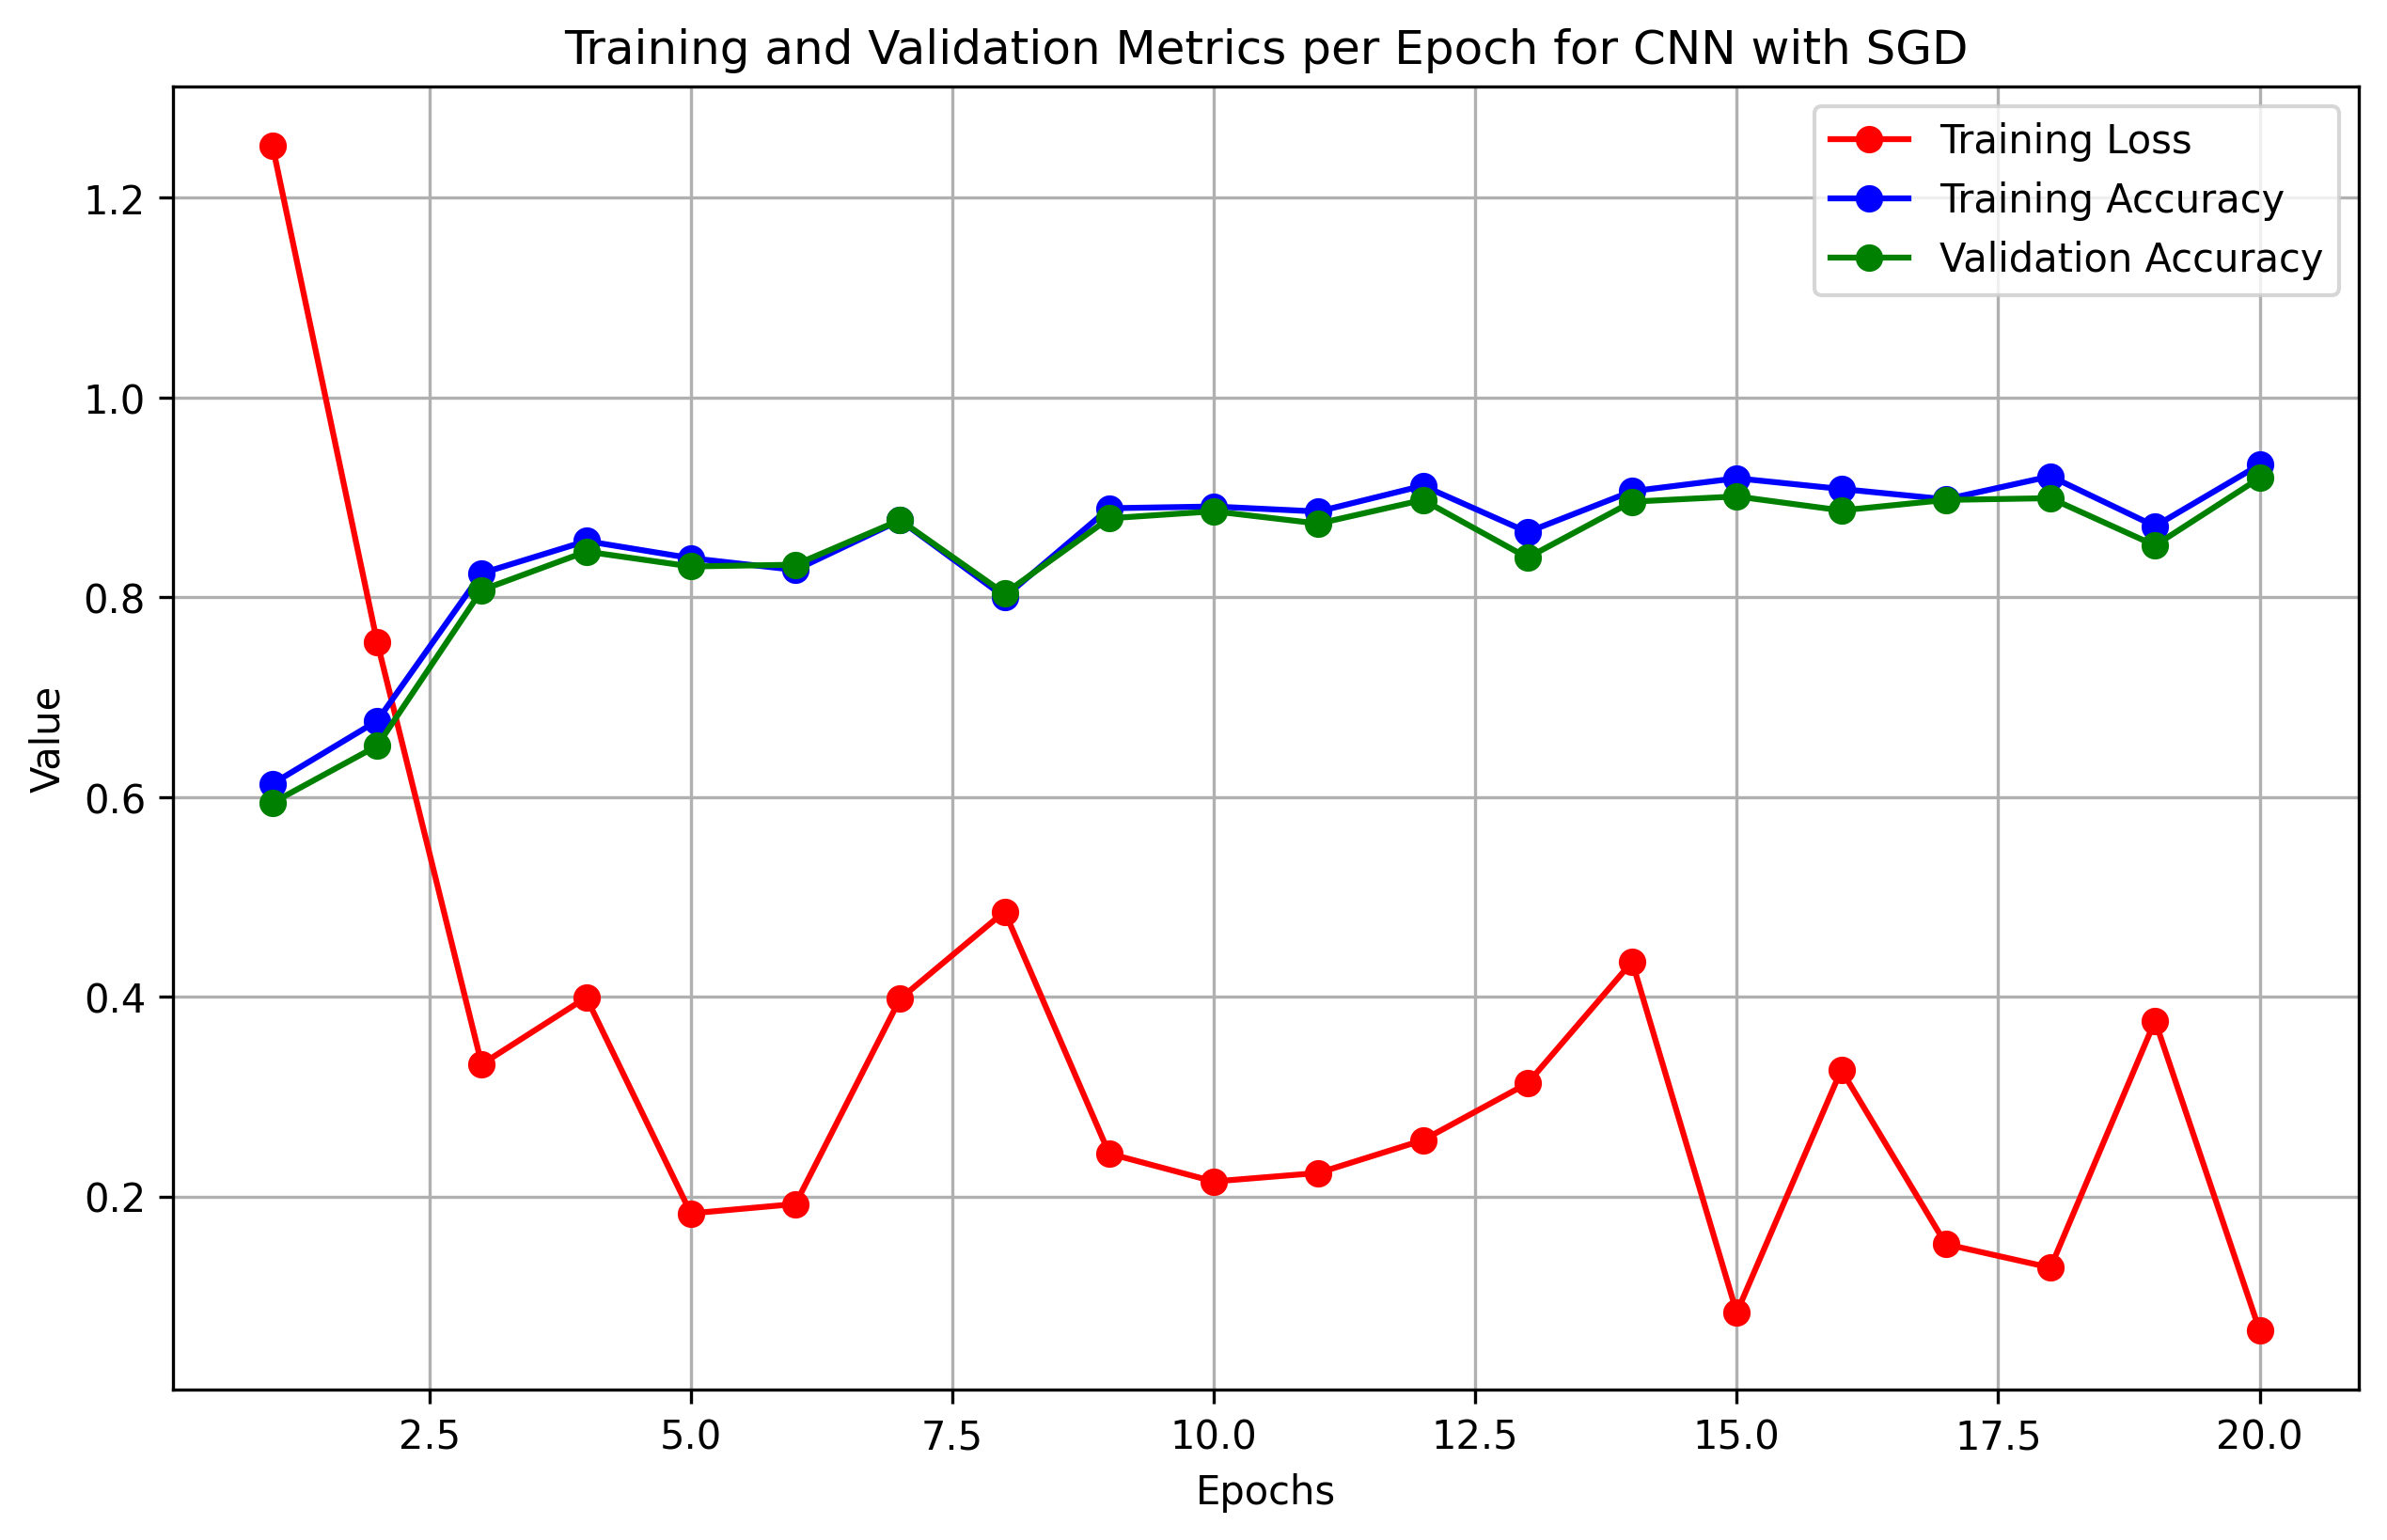

In [38]:
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(10, 6),dpi=300)
plt.plot(epochs, training_loss_sgd, label='Training Loss', color='red', marker='o')
plt.plot(epochs, training_accuracy_sgd, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs, validation_accuracy_sgd, label='Validation Accuracy', color='green', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training and Validation Metrics per Epoch for CNN with SGD')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('TV_graph SGD.png', dpi=300, bbox_inches='tight')
plt.show()


In [17]:
with torch.no_grad():
    correct = 0
    total = 0
    validation_loader_tqdm = tqdm(validation_loader, desc="Validating", leave=True)
    for images, labels in validation_loader_tqdm:
        images = images.to(device)
        lables_mapped=lables_converter(labels)
        labels = lables_mapped.to(device)
        outputs = model(images)
        values, predicted = torch.max(outputs.data, 1)
        total = total+ labels.size(0)
        correct = correct+ (predicted == labels).sum().item()
    
    print('Accuracy validation images: {} %'.format(100 * correct / total))

Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.00it/s]

Accuracy validation images: 91.41104294478528 %


In [18]:
test_accuracy_sgd=0;
with torch.no_grad():
    correct = 0
    total = 0
    test_loader_tqdm = tqdm(test_loader, desc="Testing", leave=True)
    for images, labels in test_loader_tqdm:
        images = images.to(device)
        lables_mapped=lables_converter(labels)
        labels = lables_mapped.to(device)
        outputs = model(images)
        values, predicted = torch.max(outputs.data, 1)
        total = total+ labels.size(0)
        correct = correct+ (predicted == labels).sum().item()
    test_accuracy_sgd=correct / total
    print('Accuracy test images: {} %'.format(100 * correct / total))

Testing: 100%|█████████████████████████████████████████████████████████████████████████| 45/45 [00:17<00:00,  2.59it/s]

Accuracy test images: 91.87105816398038 %


In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs=20
training_loss_adam=[]
training_accuracy_adam=[]
validation_accuracy_adam=[]
model_adam = model.to(device)
for epoch in range(num_epochs):
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=True)
    for i, (images, labels) in enumerate(train_loader_tqdm): 
        lables_mapped=lables_converter(labels)
        images = images.to(device)
        labels = lables_converter(labels).to(device)
        outputs = model_adam(images)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    training_loss_adam.append(loss.item())
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item())) 
    with torch.no_grad():
        correct = 0
        total = 0
        train_loader_tqdm = tqdm(train_loader, desc="Training", leave=True)
        for images, labels in train_loader_tqdm:
            images = images.to(device)
            lables_mapped=lables_converter(labels)
            labels = lables_mapped.to(device)
            outputs = model_adam(images)
            values, predicted = torch.max(outputs.data, 1)
            total = total+ labels.size(0)
            correct = correct+ (predicted == labels).sum().item()
        training_accuracy_adam.append(correct / total)
        print('Accuracy Traing images: {} %'.format(100 * correct / total))
    with torch.no_grad():
        correct = 0
        total = 0
        validation_loader_tqdm = tqdm(validation_loader, desc="Validating", leave=True)
        for images, labels in validation_loader_tqdm:
            images = images.to(device)
            lables_mapped=lables_converter(labels)
            labels = lables_mapped.to(device)
            outputs = model_adam(images)
            values, predicted = torch.max(outputs.data, 1)
            total = total+ labels.size(0)
            correct = correct+ (predicted == labels).sum().item()
        validation_accuracy_adam.append(correct / total)
        print('Accuracy validation images: {} %'.format(100*correct / total))

Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:44<00:00,  3.21it/s]


Epoch [1/20], Loss: 0.3813


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:51<00:00,  2.80it/s]


Accuracy Traing images: 87.92725679228747 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.04it/s]


Accuracy validation images: 85.36371603856267 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:42<00:00,  3.33it/s]


Epoch [2/20], Loss: 0.3135


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:48<00:00,  2.96it/s]


Accuracy Traing images: 87.20420683610868 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.79it/s]


Accuracy validation images: 84.22436459246275 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:44<00:00,  3.24it/s]


Epoch [3/20], Loss: 0.1444


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:50<00:00,  2.84it/s]


Accuracy Traing images: 88.3216476774759 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.92it/s]


Accuracy validation images: 85.2760736196319 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:41<00:00,  3.46it/s]


Epoch [4/20], Loss: 0.4572


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:51<00:00,  2.78it/s]


Accuracy Traing images: 88.21209465381244 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.80it/s]


Accuracy validation images: 86.06485539000876 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:47<00:00,  3.04it/s]


Epoch [5/20], Loss: 0.3777


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:50<00:00,  2.84it/s]


Accuracy Traing images: 89.89921121822962 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.82it/s]


Accuracy validation images: 87.11656441717791 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:47<00:00,  3.04it/s]


Epoch [6/20], Loss: 0.1401


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:52<00:00,  2.71it/s]


Accuracy Traing images: 90.68799298860648 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.91it/s]


Accuracy validation images: 87.02892199824716 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:44<00:00,  3.18it/s]


Epoch [7/20], Loss: 0.3964


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:50<00:00,  2.82it/s]


Accuracy Traing images: 91.1042944785276 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.81it/s]


Accuracy validation images: 87.11656441717791 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:42<00:00,  3.35it/s]


Epoch [8/20], Loss: 0.4012


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:44<00:00,  3.19it/s]


Accuracy Traing images: 89.4829097283085 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.19it/s]


Accuracy validation images: 86.59070990359334 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:39<00:00,  3.60it/s]


Epoch [9/20], Loss: 0.1267


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:48<00:00,  2.94it/s]


Accuracy Traing images: 90.863277826468 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.04it/s]


Accuracy validation images: 87.64241893076249 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:41<00:00,  3.45it/s]


Epoch [10/20], Loss: 0.2777


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:50<00:00,  2.83it/s]


Accuracy Traing images: 91.56441717791411 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.11it/s]


Accuracy validation images: 86.76599474145486 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:40<00:00,  3.57it/s]


Epoch [11/20], Loss: 0.3812


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:51<00:00,  2.77it/s]


Accuracy Traing images: 91.71779141104294 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.87it/s]


Accuracy validation images: 86.6783523225241 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:44<00:00,  3.25it/s]


Epoch [12/20], Loss: 0.1256


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:49<00:00,  2.87it/s]


Accuracy Traing images: 90.79754601226993 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.03it/s]


Accuracy validation images: 85.80192813321648 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:43<00:00,  3.27it/s]


Epoch [13/20], Loss: 0.5910


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:46<00:00,  3.09it/s]


Accuracy Traing images: 91.5863277826468 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.15it/s]


Accuracy validation images: 87.20420683610868 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:40<00:00,  3.50it/s]


Epoch [14/20], Loss: 0.1204


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:48<00:00,  2.93it/s]


Accuracy Traing images: 91.60823838737949 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.12it/s]


Accuracy validation images: 87.99298860648554 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:42<00:00,  3.38it/s]


Epoch [15/20], Loss: 0.2549


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:46<00:00,  3.04it/s]


Accuracy Traing images: 92.94478527607362 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.13it/s]


Accuracy validation images: 88.0806310254163 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:40<00:00,  3.57it/s]


Epoch [16/20], Loss: 0.3007


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [01:01<00:00,  2.33it/s]


Accuracy Traing images: 91.56441717791411 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.95it/s]


Accuracy validation images: 86.85363716038563 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:59<00:00,  2.39it/s]


Epoch [17/20], Loss: 0.2418


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:48<00:00,  2.92it/s]


Accuracy Traing images: 90.38124452234882 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.11it/s]


Accuracy validation images: 86.15249780893953 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:40<00:00,  3.53it/s]


Epoch [18/20], Loss: 0.3039


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:46<00:00,  3.05it/s]


Accuracy Traing images: 92.39702015775636 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.12it/s]


Accuracy validation images: 86.15249780893953 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:40<00:00,  3.54it/s]


Epoch [19/20], Loss: 0.0808


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:46<00:00,  3.08it/s]


Accuracy Traing images: 94.04031551270815 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.09it/s]


Accuracy validation images: 89.4829097283085 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:41<00:00,  3.48it/s]


Epoch [20/20], Loss: 0.2577


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:47<00:00,  3.01it/s]


Accuracy Traing images: 92.15600350569676 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.04it/s]

Accuracy validation images: 87.29184925503944 %


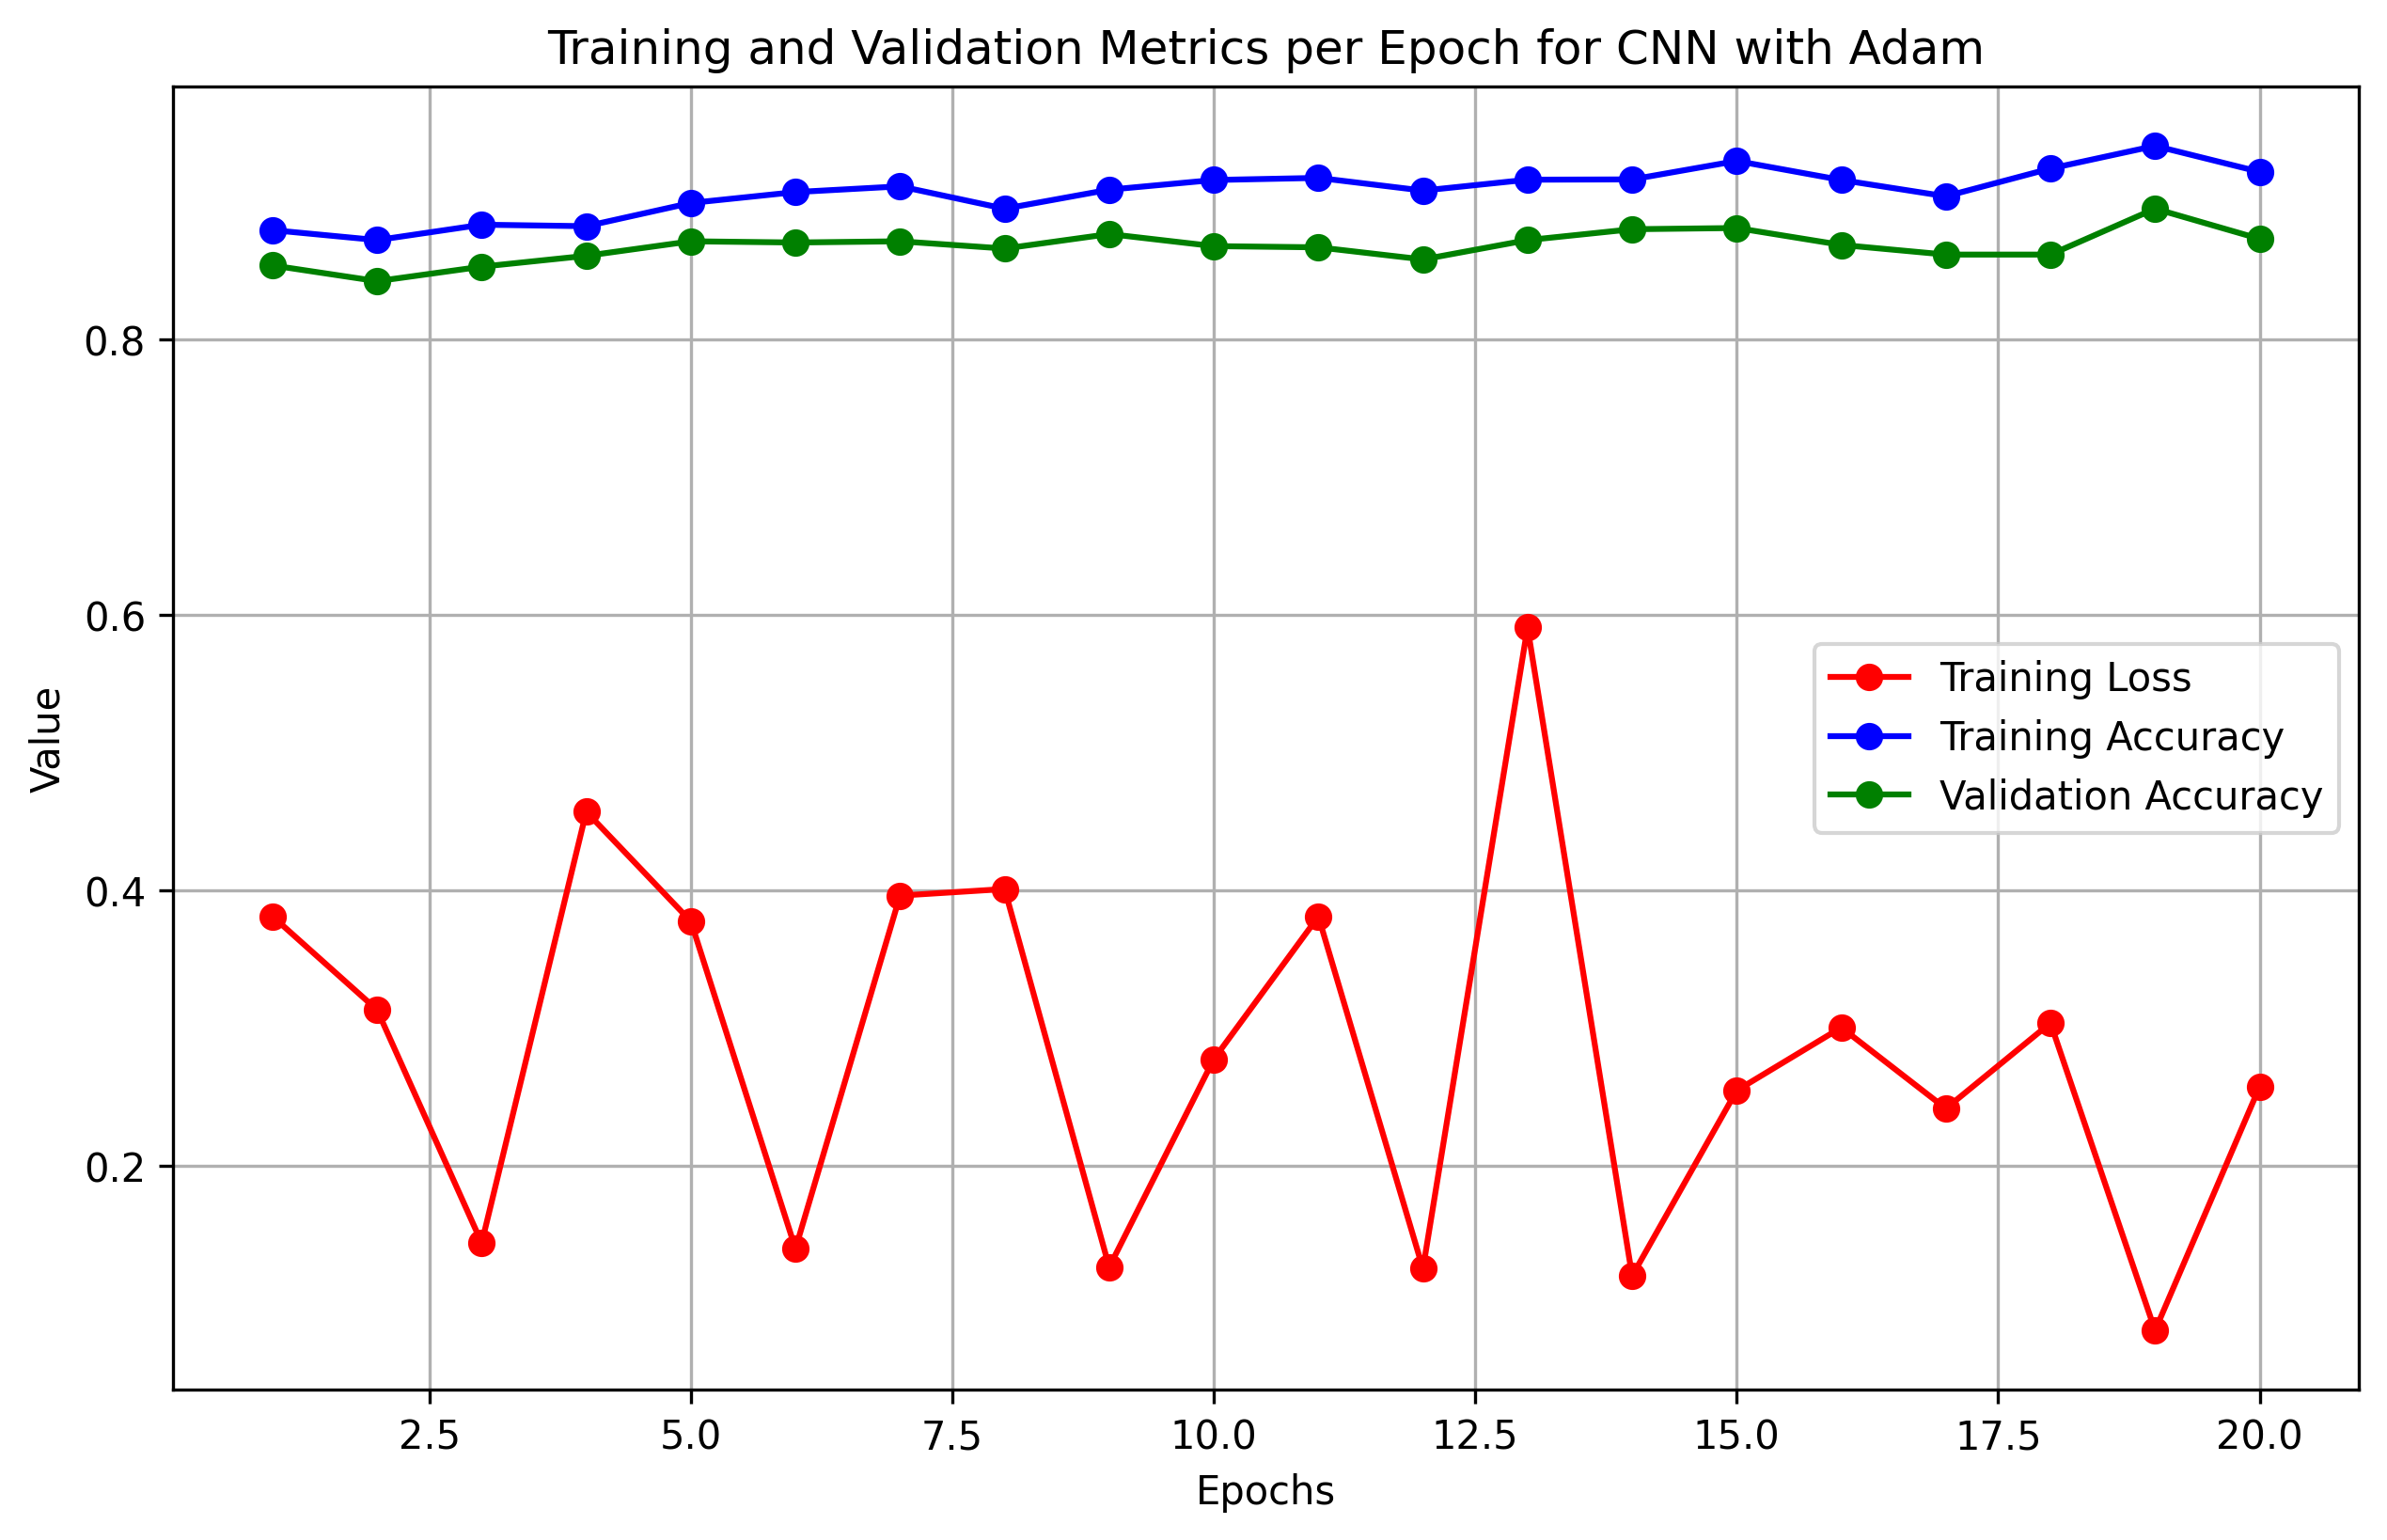

In [39]:
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(10, 6),dpi=300)
plt.plot(epochs, training_loss_adam, label='Training Loss', color='red', marker='o')
plt.plot(epochs, training_accuracy_adam, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs, validation_accuracy_adam, label='Validation Accuracy', color='green', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training and Validation Metrics per Epoch for CNN with Adam')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('TV_graph Adam.png', dpi=300, bbox_inches='tight')
plt.show()


In [21]:
with torch.no_grad():
    correct = 0
    total = 0
    validation_loader_tqdm = tqdm(validation_loader, desc="Validating", leave=True)
    for images, labels in validation_loader_tqdm:
        images = images.to(device)
        lables_mapped=lables_converter(labels)
        labels = lables_mapped.to(device)
        outputs = model_adam(images)
        values, predicted = torch.max(outputs.data, 1)
        total = total+ labels.size(0)
        correct = correct+ (predicted == labels).sum().item()
    
    print('Accuracy validation images: {} %'.format(100 * correct / total))

Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.04it/s]

Accuracy validation images: 86.59070990359334 %


In [22]:
test_accuracy_adam=0;
with torch.no_grad():
    correct = 0
    total = 0
    test_loader_tqdm = tqdm(test_loader, desc="Testing", leave=True)
    for images, labels in test_loader_tqdm:
        images = images.to(device)
        lables_mapped=lables_converter(labels)
        labels = lables_mapped.to(device)
        outputs = model_adam(images)
        values, predicted = torch.max(outputs.data, 1)
        total = total+ labels.size(0)
        correct = correct+ (predicted == labels).sum().item()
        test_accuracy_adam=correct / total
    print('Accuracy test images: {} %'.format(100 * correct / total))

Testing: 100%|█████████████████████████████████████████████████████████████████████████| 45/45 [00:24<00:00,  1.83it/s]

Accuracy test images: 88.2270497547302 %


In [23]:
model_resnet=model_lr3 = models.resnet50(pretrained=True)
model_resnet.conv1 = nn.Conv2d(
    in_channels=1,
    out_channels=model_resnet.conv1.out_channels, 
    kernel_size=model_resnet.conv1.kernel_size, 
    stride=model_resnet.conv1.stride,  
    padding=model_resnet.conv1.padding,  
    bias=model_resnet.conv1.bias is not None  
)

model_resnet.fc = nn.Linear(in_features=model_resnet.fc.in_features, out_features=4)
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.01)

C:\Users\marut\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\marut\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
m_epochs=20
model_resnet = model_resnet.to(device)
training_loss_resnet=[]
training_accuracy_resnet=[]
validation_accuracy_resnet=[]
for epoch in range(num_epochs):
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=True)
    for i, (images, labels) in enumerate(train_loader_tqdm): 
        lables_mapped=lables_converter(labels)
        images = images.to(device)
        labels = lables_converter(labels).to(device)
        outputs = model_resnet(images)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    training_loss_resnet.append(loss.item())
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item())) 
    with torch.no_grad():
        correct = 0
        total = 0
        train_loader_tqdm = tqdm(train_loader, desc="Training Testing", leave=True)
        for images, labels in train_loader_tqdm:
            images = images.to(device)
            lables_mapped=lables_converter(labels)
            labels = lables_mapped.to(device)
            outputs = model_resnet(images)
            values, predicted = torch.max(outputs.data, 1)
            total = total+ labels.size(0)
            correct = correct+ (predicted == labels).sum().item()
        training_accuracy_resnet.append(correct / total)
        print('Accuracy Traing images: {} %'.format(100 * correct / total))
    with torch.no_grad():
        correct = 0
        total = 0
        validation_loader_tqdm = tqdm(validation_loader, desc="Validating", leave=True)
        for images, labels in validation_loader_tqdm:
            images = images.to(device)
            lables_mapped=lables_converter(labels)
            labels = lables_mapped.to(device)
            outputs = model_resnet(images)
            values, predicted = torch.max(outputs.data, 1)
            total = total+ labels.size(0)
            correct = correct+ (predicted == labels).sum().item()
        validation_accuracy_resnet.append(correct / total)
        print('Accuracy validation images: {} %'.format(100*correct / total))

Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:53<00:00,  2.69it/s]


Epoch [1/20], Loss: 0.4925


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:13<00:00,  1.95it/s]


Accuracy Traing images: 74.079754601227 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.97it/s]


Accuracy validation images: 71.77914110429448 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:52<00:00,  2.74it/s]


Epoch [2/20], Loss: 0.5065


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:12<00:00,  1.97it/s]


Accuracy Traing images: 87.13847502191061 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:17<00:00,  2.02it/s]


Accuracy validation images: 84.8378615249781 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:51<00:00,  2.78it/s]


Epoch [3/20], Loss: 0.3166


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:10<00:00,  2.04it/s]


Accuracy Traing images: 89.7020157756354 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:17<00:00,  2.03it/s]


Accuracy validation images: 89.04469763365469 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:51<00:00,  2.79it/s]


Epoch [4/20], Loss: 0.1490


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:11<00:00,  1.99it/s]


Accuracy Traing images: 90.75372480280456 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.97it/s]


Accuracy validation images: 89.21998247151622 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:52<00:00,  2.71it/s]


Epoch [5/20], Loss: 0.1551


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:12<00:00,  1.98it/s]


Accuracy Traing images: 91.43295354951796 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.91it/s]


Accuracy validation images: 90.70990359333918 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [01:02<00:00,  2.28it/s]


Epoch [6/20], Loss: 0.1376


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:20<00:00,  1.77it/s]


Accuracy Traing images: 87.37949167397021 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:17<00:00,  2.01it/s]


Accuracy validation images: 85.36371603856267 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:56<00:00,  2.51it/s]


Epoch [7/20], Loss: 0.5653


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:12<00:00,  1.97it/s]


Accuracy Traing images: 92.37510955302366 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.99it/s]


Accuracy validation images: 89.4829097283085 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:51<00:00,  2.76it/s]


Epoch [8/20], Loss: 0.2641


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:13<00:00,  1.95it/s]


Accuracy Traing images: 92.55039439088519 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.98it/s]


Accuracy validation images: 89.4829097283085 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:53<00:00,  2.67it/s]


Epoch [9/20], Loss: 0.1095


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:13<00:00,  1.96it/s]


Accuracy Traing images: 95.0920245398773 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.97it/s]


Accuracy validation images: 92.2874671340929 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:52<00:00,  2.72it/s]


Epoch [10/20], Loss: 0.0639


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:13<00:00,  1.95it/s]


Accuracy Traing images: 94.91673970201578 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.99it/s]


Accuracy validation images: 91.67397020157756 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:52<00:00,  2.73it/s]


Epoch [11/20], Loss: 0.3466


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:12<00:00,  1.96it/s]


Accuracy Traing images: 95.61787905346188 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.97it/s]


Accuracy validation images: 92.63803680981596 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:52<00:00,  2.73it/s]


Epoch [12/20], Loss: 0.2609


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:12<00:00,  1.96it/s]


Accuracy Traing images: 93.58019281332164 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:17<00:00,  2.00it/s]


Accuracy validation images: 89.4829097283085 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:52<00:00,  2.70it/s]


Epoch [13/20], Loss: 0.3848


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:13<00:00,  1.95it/s]


Accuracy Traing images: 96.80105170902716 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:17<00:00,  2.02it/s]


Accuracy validation images: 94.12795793163892 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:51<00:00,  2.78it/s]


Epoch [14/20], Loss: 0.0414


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:12<00:00,  1.97it/s]


Accuracy Traing images: 96.40666082383873 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.97it/s]


Accuracy validation images: 92.37510955302366 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:52<00:00,  2.75it/s]


Epoch [15/20], Loss: 0.1010


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:12<00:00,  1.98it/s]


Accuracy Traing images: 97.37072743207713 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.93it/s]


Accuracy validation images: 93.86503067484662 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:51<00:00,  2.75it/s]


Epoch [16/20], Loss: 0.0194


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:12<00:00,  1.98it/s]


Accuracy Traing images: 94.21560035056967 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:17<00:00,  2.02it/s]


Accuracy validation images: 89.83347940403155 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:52<00:00,  2.72it/s]


Epoch [17/20], Loss: 0.2109


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:10<00:00,  2.02it/s]


Accuracy Traing images: 97.94040315512709 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.98it/s]


Accuracy validation images: 93.60210341805434 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:52<00:00,  2.72it/s]


Epoch [18/20], Loss: 0.0301


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:12<00:00,  1.97it/s]


Accuracy Traing images: 97.45836985100789 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:17<00:00,  2.04it/s]


Accuracy validation images: 92.2874671340929 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:52<00:00,  2.71it/s]


Epoch [19/20], Loss: 0.0752


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:12<00:00,  1.98it/s]


Accuracy Traing images: 98.46625766871166 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:17<00:00,  2.02it/s]


Accuracy validation images: 92.72567922874671 %


Training: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [01:01<00:00,  2.34it/s]


Epoch [20/20], Loss: 0.0737


Training Testing: 100%|██████████████████████████████████████████████████████████████| 143/143 [01:13<00:00,  1.94it/s]


Accuracy Traing images: 97.15162138475021 %


Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.95it/s]

Accuracy validation images: 92.02453987730061 %


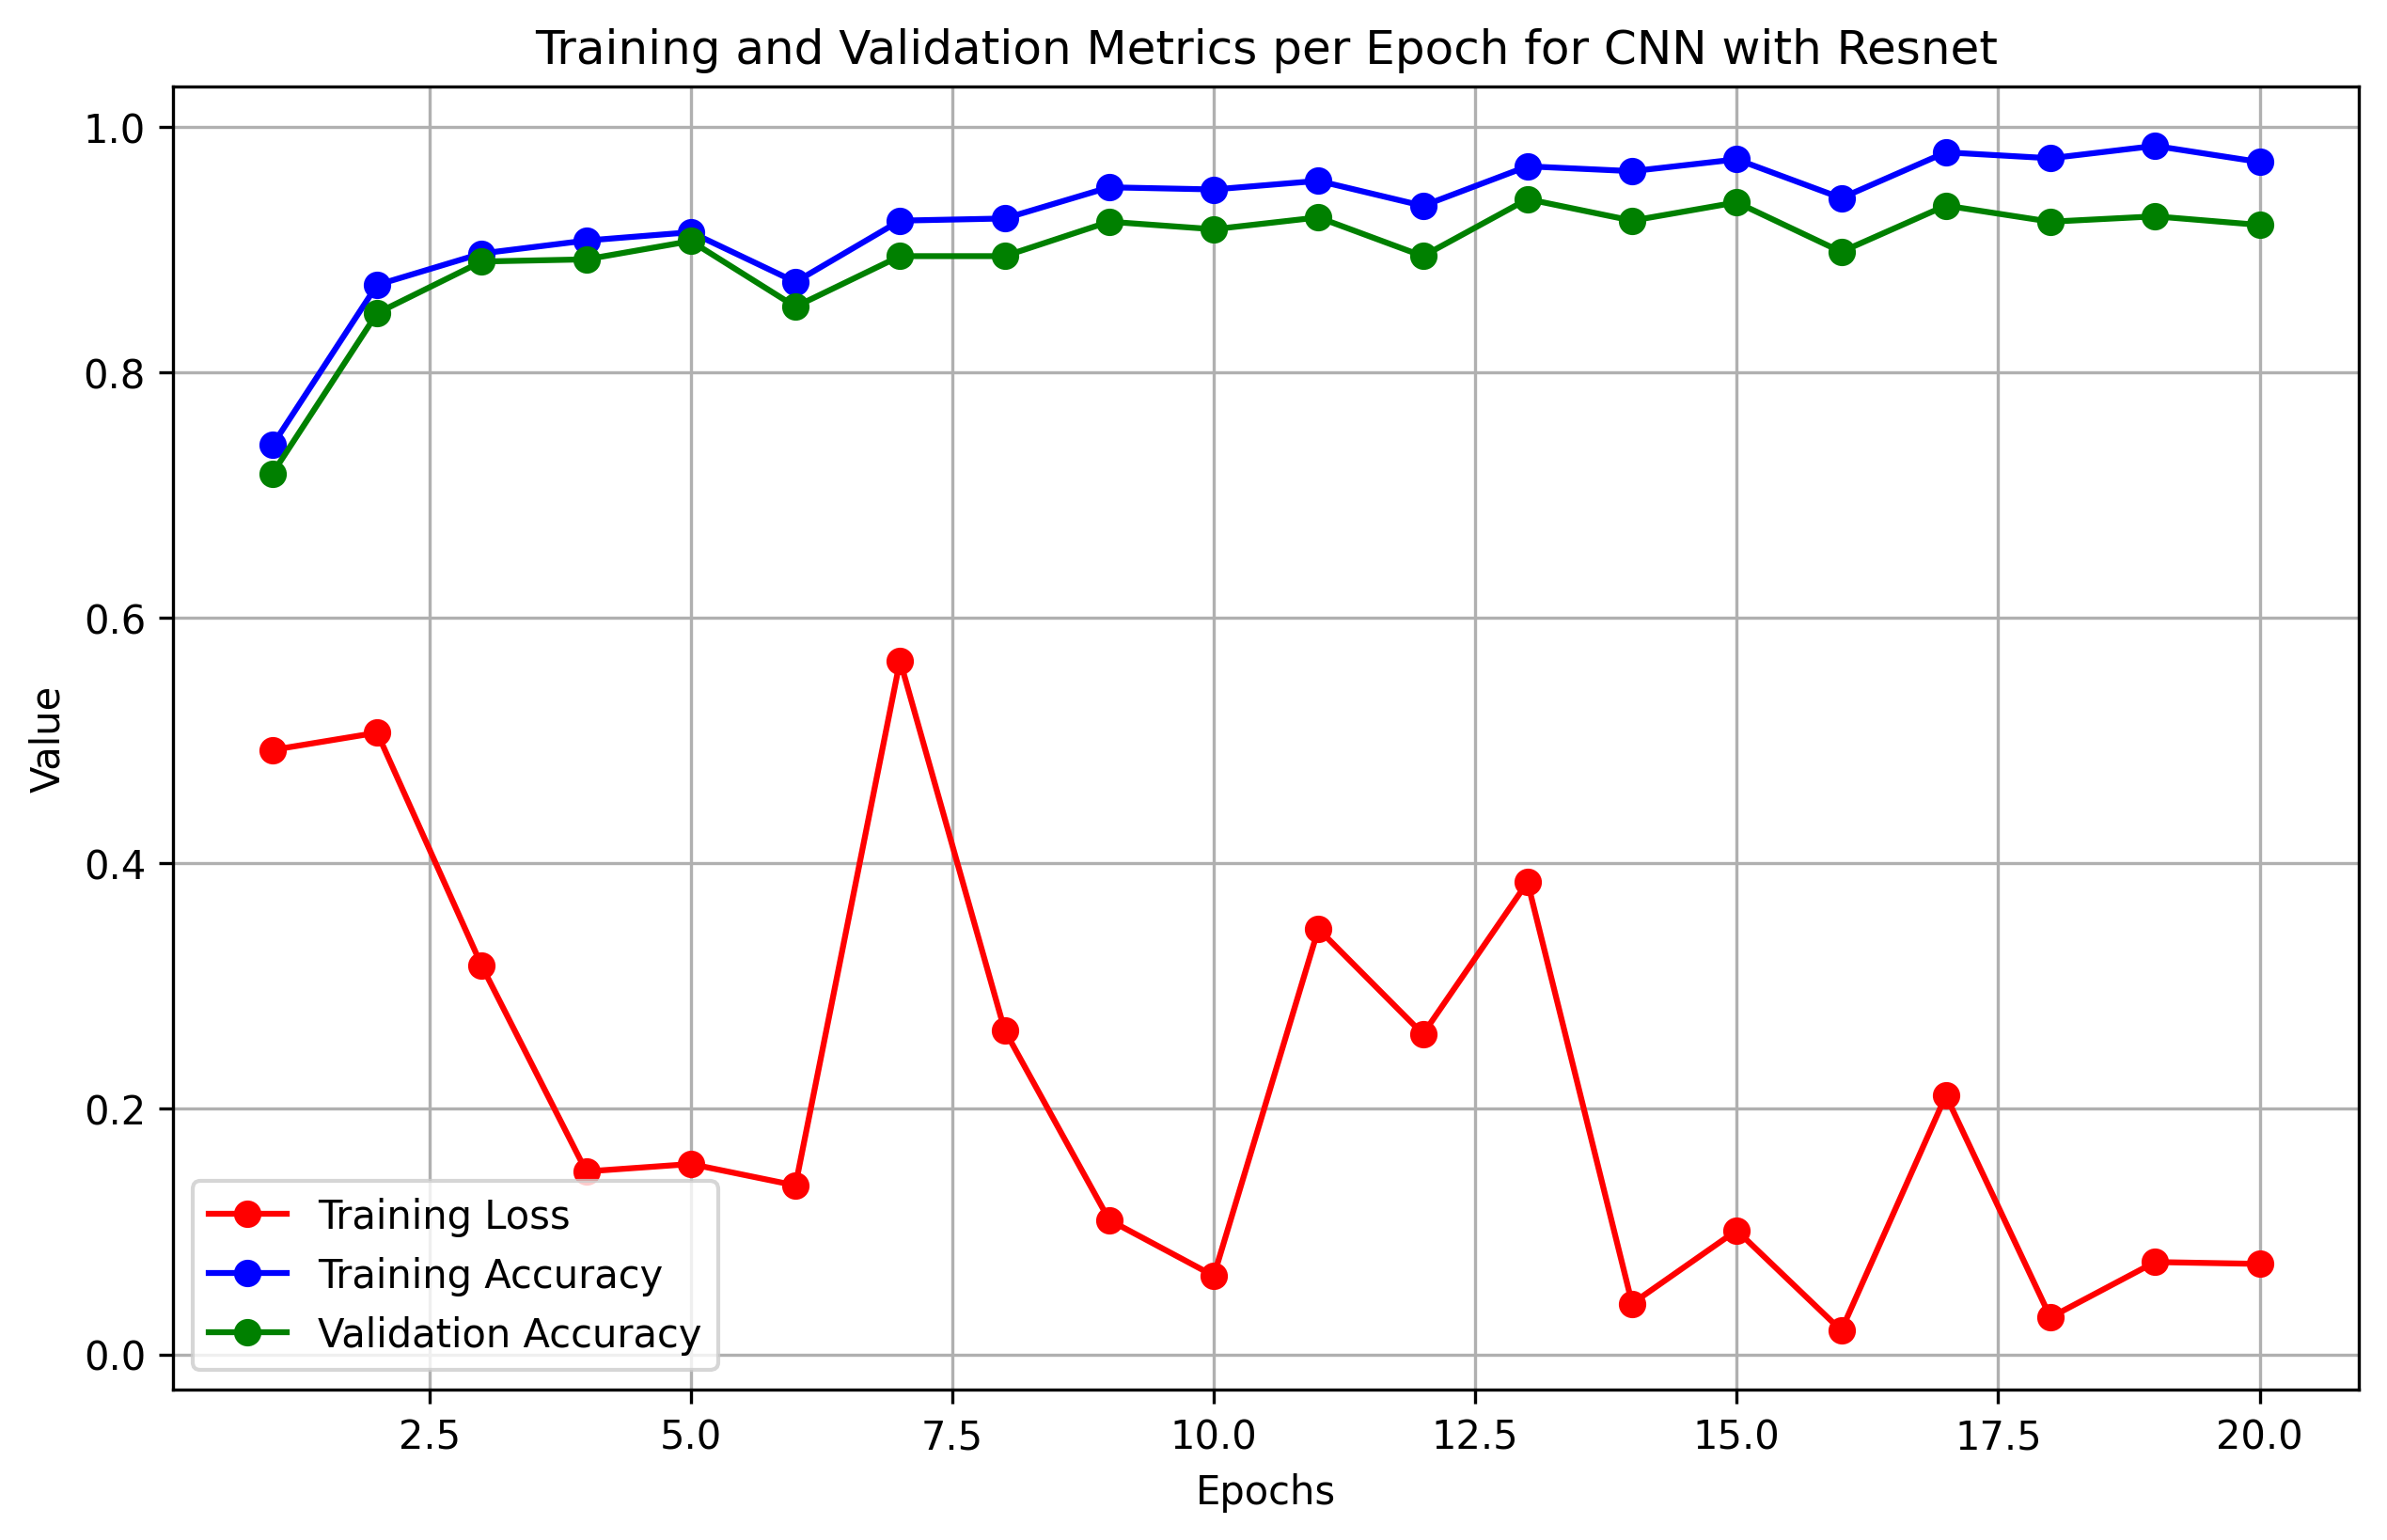

In [40]:
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(10, 6),dpi=300)
plt.plot(epochs, training_loss_resnet, label='Training Loss', color='red', marker='o')
plt.plot(epochs, training_accuracy_resnet, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs, validation_accuracy_resnet, label='Validation Accuracy', color='green', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training and Validation Metrics per Epoch for CNN with Resnet')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('TV_graph Resnet.png', dpi=300, bbox_inches='tight')
plt.show()


In [25]:
with torch.no_grad():
    correct = 0
    total = 0
    validation_loader_tqdm = tqdm(validation_loader, desc="Validating", leave=True)
    for images, labels in validation_loader_tqdm:
        images = images.to(device)
        lables_mapped=lables_converter(labels)
        labels = lables_mapped.to(device)
        outputs = model_resnet(images)
        values, predicted = torch.max(outputs.data, 1)
        total = total+ labels.size(0)
        correct = correct+ (predicted == labels).sum().item()
    
    print('Accuracy validation images: {} %'.format(100 * correct / total))

Validating: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:17<00:00,  2.03it/s]

Accuracy validation images: 92.2874671340929 %


In [26]:
test_accuracy_resnet=correct / total
with torch.no_grad():
    correct = 0
    total = 0
    test_loader_tqdm = tqdm(test_loader, desc="Testing", leave=True)
    for images, labels in test_loader_tqdm:
        images = images.to(device)
        lables_mapped=lables_converter(labels)
        labels = lables_mapped.to(device)
        outputs = model_resnet(images)
        values, predicted = torch.max(outputs.data, 1)
        total = total+ labels.size(0)
        correct = correct+ (predicted == labels).sum().item()
    
    print('Accuracy test images: {} %'.format(100 * correct / total))

Testing: 100%|█████████████████████████████████████████████████████████████████████████| 45/45 [00:23<00:00,  1.89it/s]

Accuracy test images: 92.01121233356692 %


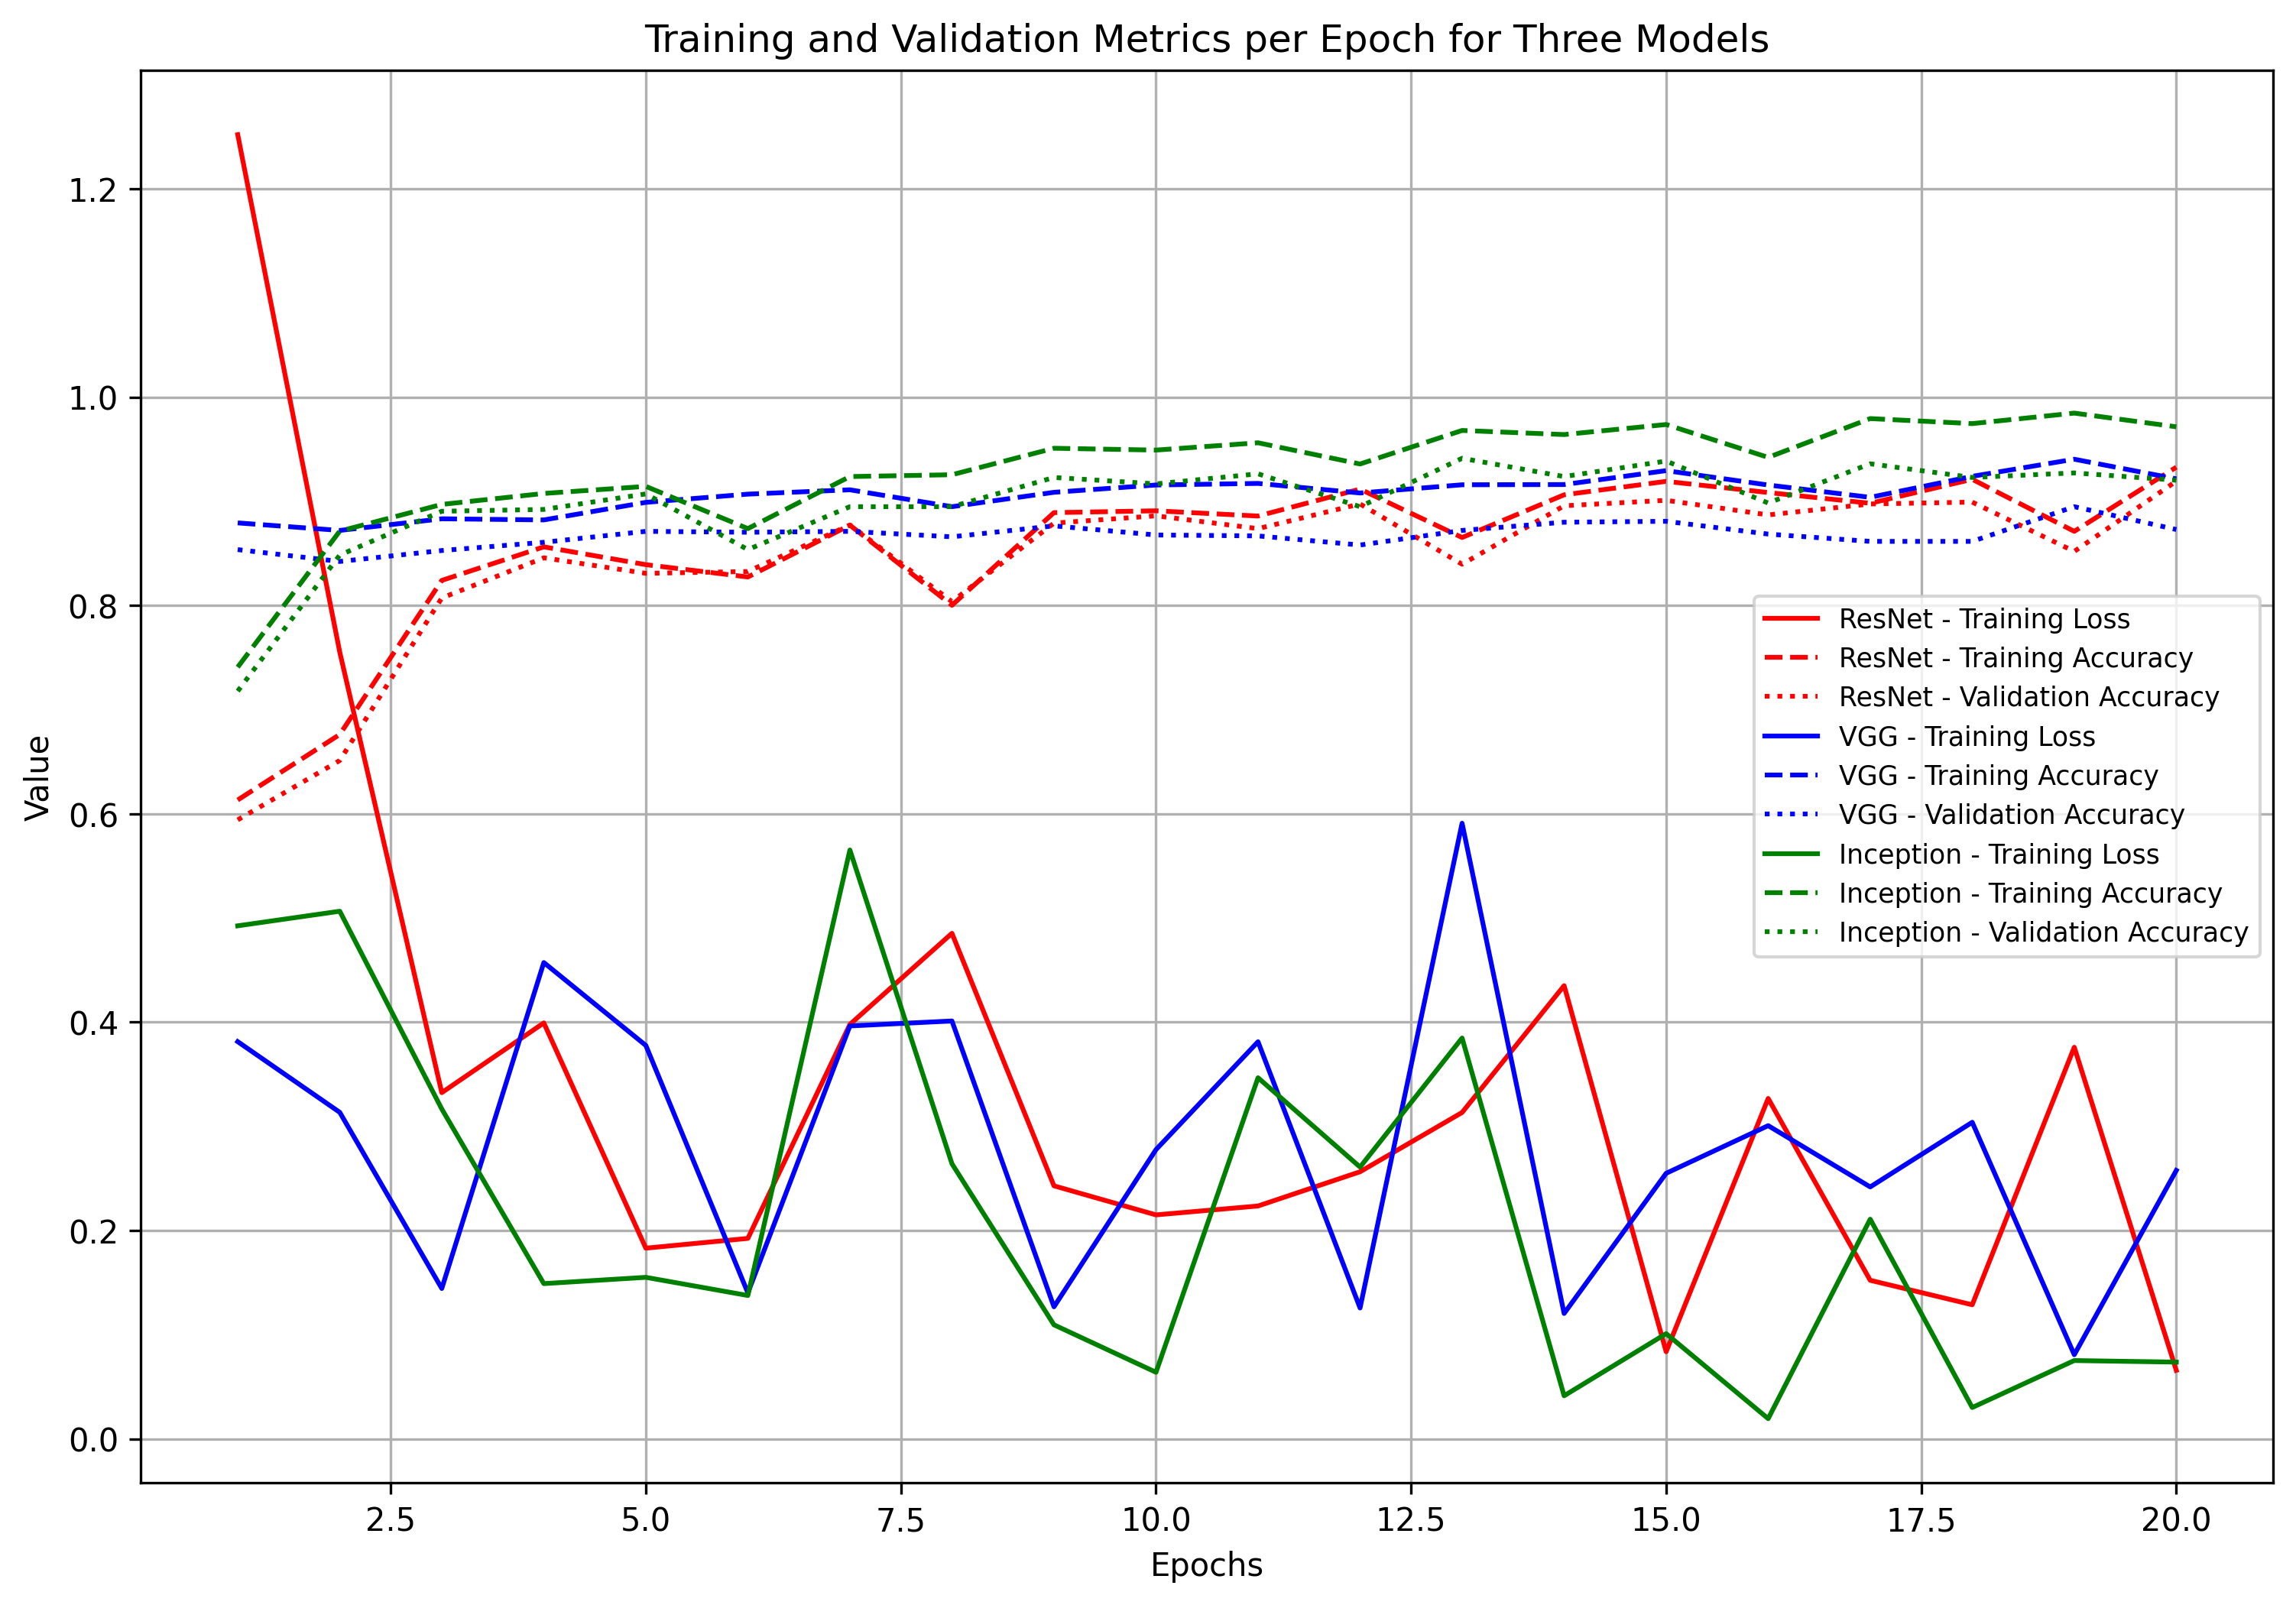

In [36]:
plt.figure(figsize=(12, 8), dpi=300)
plt.plot(epochs, training_loss_sgd, label='ResNet - Training Loss', color='red', linestyle='-')
plt.plot(epochs, training_accuracy_sgd, label='ResNet - Training Accuracy', color='red', linestyle='--')
plt.plot(epochs, validation_accuracy_sgd, label='ResNet - Validation Accuracy', color='red', linestyle=':')
plt.plot(epochs, training_loss_adam, label='VGG - Training Loss', color='blue', linestyle='-')
plt.plot(epochs, training_accuracy_adam, label='VGG - Training Accuracy', color='blue', linestyle='--')
plt.plot(epochs, validation_accuracy_adam, label='VGG - Validation Accuracy', color='blue', linestyle=':')
plt.plot(epochs, training_loss_resnet, label='Inception - Training Loss', color='green', linestyle='-')
plt.plot(epochs, training_accuracy_resnet, label='Inception - Training Accuracy', color='green', linestyle='--')
plt.plot(epochs, validation_accuracy_resnet, label='Inception - Validation Accuracy', color='green', linestyle=':')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training and Validation Metrics per Epoch for Three Models')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.savefig('comparison_graph_models.png', dpi=300, bbox_inches='tight')
plt.show()